# BAL pseudobulk analysis, pt. 4

In [1]:
import collections
import itertools
import functools
import json
import math
import os
import re
import sys
import pathlib
import datetime
import hashlib

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import decoupler
import requests
import upsetplot

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [5]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [6]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [7]:
%config InlineBackend.figure_format = "retina"

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [9]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [10]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [11]:
DEG_DIR = DATA / '11_pseudobulk-v3'

In [12]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [13]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [ ]:
MODEL = 'degs-status-sex'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-control.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-ssc.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_control': go_ctrl,
        'go_ssc': go_ssc,
    }


def process_cell_type(folder, data_folder):
    info = {}

    clust = get_cell_type_from_slug(folder.name, ds_processed)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [26]:
data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name)

In [28]:
data = {
    k.replace('_', ' ')\
        .replace('MoAM-3', 'MoAM-2')\
        .replace('MoAM-4', 'MoAM-3')\
        .replace('Perivascular', 'Interstitial'): v
    for k, v in data.items()
}

In [19]:
msigdb = decoupler.get_resource('MSigDB', organism='human')

In [20]:
hallmark = msigdb[msigdb.collection.eq('hallmark')]

In [21]:
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])]

In [22]:
PF_GENESET_URL = (
    'https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/'
    'pulmonary+fibrosis/DISEASES+Text-mining+Gene-Disease+Assocation+Evidence+Scores'
)
PF_GENESET_FILE = 'Harmonizome_PF_set.json'
PF_GENESET_SHA1 = '3f3dd4f618e335382982d16e0afae9f2240dcbd6'

In [23]:
if not os.path.exists(PF_GENESET_FILE):
    with open(PF_GENESET_FILE, 'w') as f:
        contents = requests.get(PF_GENESET_URL).text
        f.write(contents)
        print(f'Downloaded PF geneset with sha1 {hashlib.sha1(contents.encode()).hexdigest()}')
contents = open(PF_GENESET_FILE).read()
if hashlib.sha1(contents.encode()).hexdigest() != PF_GENESET_SHA1:
    print('SHA1 of PF gene set does not match the stored one')
pf_genes = json.loads(contents)
pf_genes = [x['gene']['symbol'] for x in pf_genes['associations']]

In [24]:
hallmark = pd.concat([
    hallmark,
    pd.DataFrame(dict(genesymbol=pf_genes, collection='Harmonizome', geneset='Harmonizome_PF'))
])

# 1. GSEA results on the filtered DEGs

In [29]:
result = []
GSEA_PATH = DATA / '11e_degs_gsea'
for k, ct_info in data.items():
    ct_path = GSEA_PATH / k
    os.makedirs(ct_path, exist_ok=True)
    ct_info['filtered_degs'].to_csv(GSEA_PATH / k / 'degs.csv')
    if not (ct_path / 'gsea.csv').exists():
        print(f'Cell type {k} GSEA results missing, run snakemake')
    else:
        enriched = pd.read_csv(ct_path / 'gsea.csv', index_col=0)
        enriched['cell_type'] = k
        enriched['n_genes'] = len(ct_info['filtered_degs'])
        enriched['n_degs'] = ct_info['filtered_degs'].padj.lt(0.05).sum()
        result.append(enriched)

In [30]:
result = pd.concat(result)

Remove Harmonizome pathway: not interested anymore

In [31]:
result = result.loc[result.Term.ne('Harmonizome_PF')].copy()

Remove exactly `0` p-values (improbable), set them to minimum p-value times `0.01`.

In [32]:
result['p-value'] = result['NOM p-value'].copy()
idx = result['p-value'].eq(0)
min_p_val = result['p-value'][~idx].min()
result.loc[idx, 'p-value'] = min_p_val * 0.01

In [33]:
print(f'P-values exactly 0: {idx.sum()}')

P-values exactly 0: 30


In [34]:
result['padj'] = statsmodels.stats.multitest.fdrcorrection(result['p-value'])[1]

In [38]:
result.cell_type = result.cell_type.replace('MoAM-2 mature', 'MoAM-2')

In [39]:
result.to_csv('11e_degs_gsea.csv')

In [49]:
result.to_csv('00_figures/Table_S3_SSc_vs_control_gsea.csv', index=False)

In [40]:
result['-log10(padj)'] = -np.log10(result.padj)

In [41]:
result['-log10(padj)'] *= np.sign(result.NES)

In [42]:
result_df = result.pivot_table(
    index='cell_type',
    columns='Term',
    values='-log10(padj)'
)

In [43]:
result_df_plot = result_df.fillna(0).T

In [44]:
rownames = result_df.columns.str.replace('HALLMARK_', '')

In [45]:
stars = np.empty_like(result_df_plot, dtype=str)
stars[result_df_plot.abs().gt(-np.log10(0.05))] = '*'

In [46]:
def process_hallmark_name(name):
    short_words = ('ACID', 'VIA', 'BETA', 'LATE', 'BILE', 'HEME')
    result = []
    words = name.split('_')
    for word in words:
        if re.search(r'\d', word) or len(word) < 5 and word not in short_words:
            result.append(word)
        else:
            result.append(word.lower())
    result = ' '.join(result)
    result = result[0].capitalize() + result[1:]
    return result

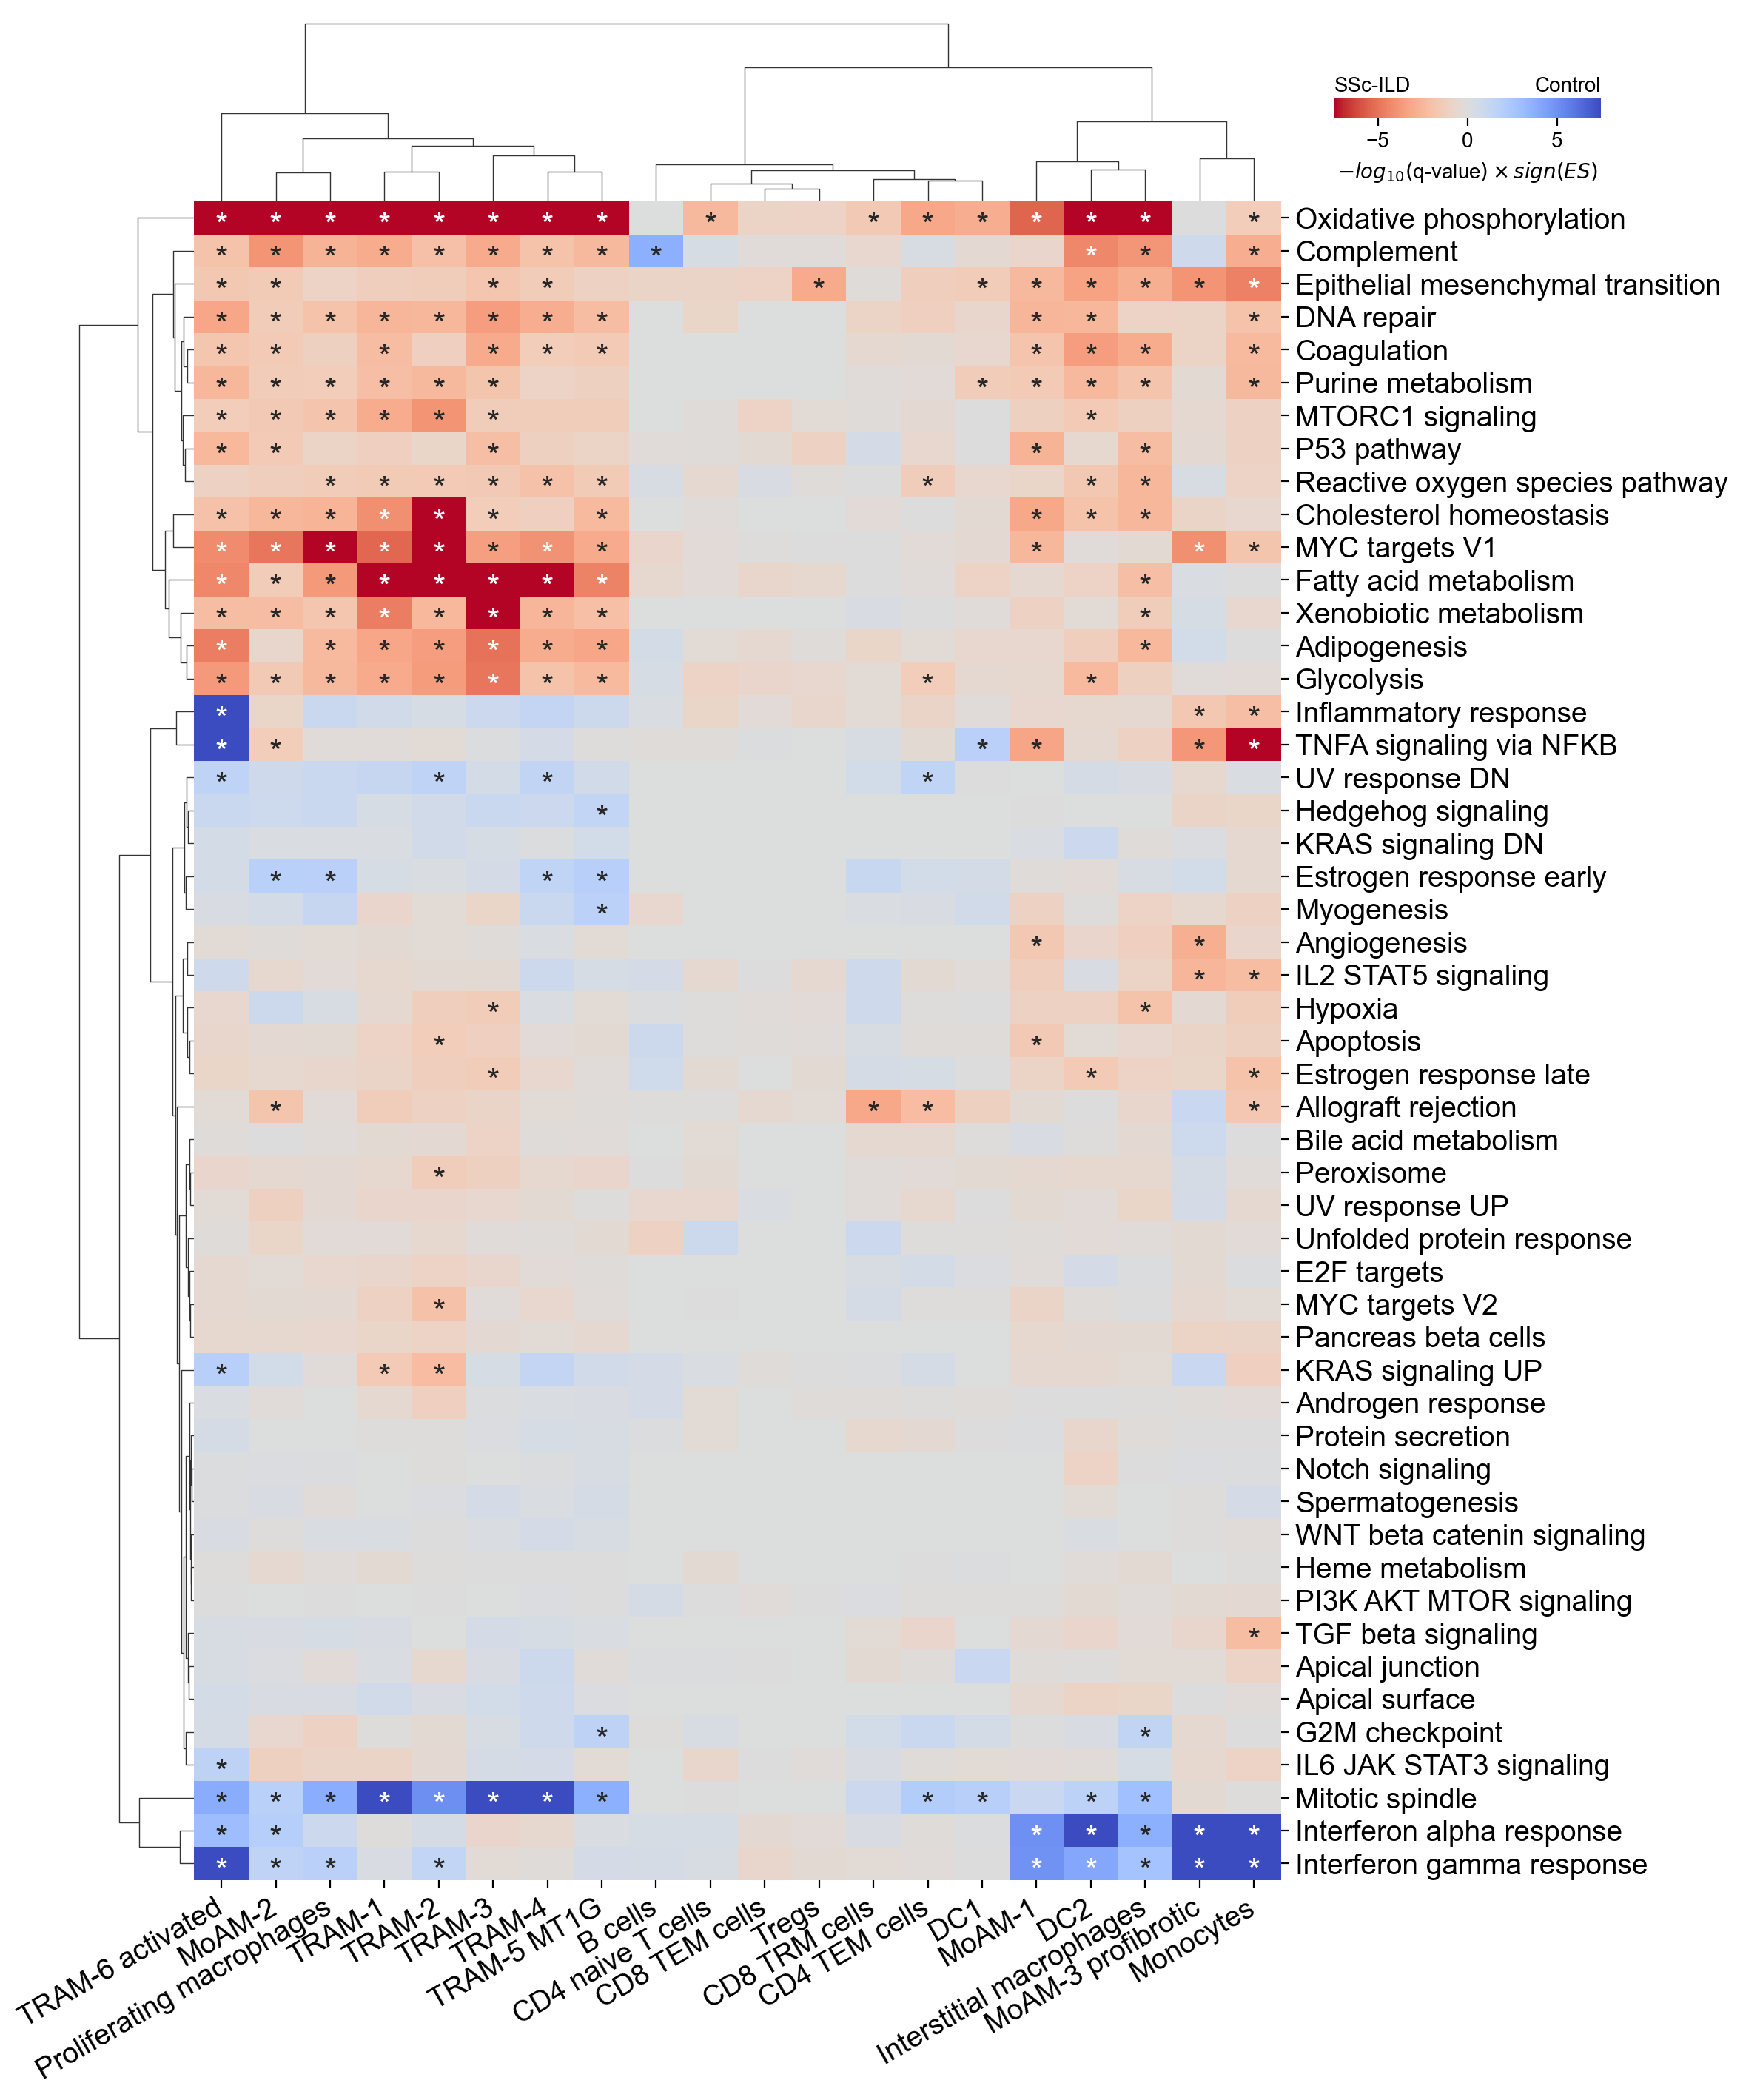

In [47]:
cg = sns.clustermap(
    result_df_plot,
    method='ward',
    figsize=(12, 14),
    dendrogram_ratio=0.1,
    cbar_pos=(0.8, 0.82, 0.08, 0.02),
    cbar_kws=dict(
        label='$-log_{10}($q-value$) \\times sign(ES)$',
        orientation='horizontal'
    ),
    xticklabels=result_df.index,
    yticklabels=[process_hallmark_name(x) for x in rownames],
    cmap='coolwarm_r',
    annot=stars,
    fmt='',
    annot_kws=dict(
        va='center_baseline',
        fontsize=16
    )
)
cg.ax_cbar.annotate('SSc-ILD', (0, 1.3), xycoords='axes fraction', ha='left')
cg.ax_cbar.annotate('Control', (1, 1.3), xycoords='axes fraction', ha='right')

cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.set_ylabel('')

cg.ax_heatmap.set_xticklabels(
    cg.ax_heatmap.get_xticklabels(),
    fontsize=14,
    rotation=30,
    ha='right'
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in cg.ax_heatmap.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

cg.ax_heatmap.set_yticklabels(
    cg.ax_heatmap.get_yticklabels(),
    fontsize=14,
)

for t in cg.ax_heatmap.texts:
    if t.get_text() == '*':
        p = t.get_position()
        t.set_position((p[0], p[1] + 0.2))

cg.ax_col_dendrogram.figure.subplots_adjust(left=0.05, bottom=0.1, top=1, right=0.73)
cg.ax_cbar.set_position((0.76, 0.95, 0.15, 0.01))

cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2C_gsea.pdf', dpi=300)

## Save for Morpheus

In [38]:
GENERATOR = 'Nick'

In [39]:
GSEA_DIR = pathlib.Path('11e_gsea')

In [40]:
os.makedirs(GSEA_DIR, exist_ok=True)

In [41]:
result_df_morpheus = result_df_plot.copy()
result_df_morpheus.index = result_df_morpheus.index.str.replace('HALLMARK_', '')
result_df_morpheus.to_csv(GSEA_DIR / 'gsea.tsv', sep='\t')

In [42]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>Pathogen comparisons GSEA</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #morpheus-container {
            width: auto;
            height: auto;
            min-width: 1200px;
            min-height: 800px;
            visibility: hidden;
        }
      </style>
    <link rel="stylesheet" href="https://software.broadinstitute.org/morpheus/css/morpheus-latest.min.css">
    <script>if (typeof module === 'object') {
    window.module = module;
    module = undefined;

    }</script>

    <script type="text/javascript" src="https://software.broadinstitute.org/morpheus/js/morpheus-external-latest.min.js"></script>
    <script src="https://software.broadinstitute.org/morpheus/js/morpheus-latest.min.js"></script>
</head>
<body>
    <div class="header">
        <h2>GSEA on SSc vs HC 10x 3' V3 comparisons (significant is >1.3)</h2>
        Generated by %s on %s<br/><br/>
        <b>Red is SSc, Blue is Healthy</b>
    </div>
    <div id="morpheus-container"></div>

    <script type="text/javascript">
        window.heatmap = new morpheus.HeatMap({
            el: document.querySelector('#morpheus-container'),
            name: "GSEA on v3 DEGs",
            dataset: "gsea.tsv",
            rows: [
                {field: "id", display: ["text"]}
            ],
            columns: [
                {field: "id", display: ["color", "text"]}
            ],
            columnColorModel: {
            },
            rowColorModel: {
            },
            colorScheme: { // optional color scheme. default is relative
                type: 'fixed',
                map: [{
                    value: -5,
                    color: '#ff0000'
                }, {
                    value: 0,
                    color: '#ffffff'
                }, {
                    value: 5,
                    color: '#0000ff'
                }],
                conditions: [
                    {inheritColor: false, shape: 'diamond', v1: 1.30103, v1Op: 'gt', color: 'black'},
                    {inheritColor: false, shape: 'diamond', v2: -1.30103, v2Op: 'lt', color: 'black'}
                ]
            },
            tools: [{ name: "Hierarchical Clustering", params: {cluster: "Rows"} }]
        });
        window.onload = function() {
            window.setTimeout(function() {
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                document.getElementById('morpheus-container').style.visibility = 'visible';
            }, 200)
        }
    </script>
</body>
</html>
"""

In [43]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p')
)

In [44]:
with open(GSEA_DIR / 'index.html', 'w') as out:
    out.write(html)

# 2. Analyze GSEA results

## 2.1 OxPhos

Cell types with significant enrichment in OxPhos on the SSc-ILD side

In [45]:
result.loc[
    result.Term.eq('HALLMARK_OXIDATIVE_PHOSPHORYLATION')
    & result.padj.lt(0.05)
    & result.ES.lt(0)
].cell_type

30                CD4 TEM cells
27            CD4 naive T cells
30                CD8 TRM cells
30                          DC1
34                          DC2
35                       MoAM-1
35                MoAM-2 mature
35                    Monocytes
35     Interstitial macrophages
35    Proliferating macrophages
35                       TRAM-1
35                       TRAM-2
35                       TRAM-3
35                       TRAM-4
35                  TRAM-5 MT1G
35             TRAM-6 activated
Name: cell_type, dtype: object

In [46]:
oxphos = result.loc[
    result.Term.eq('HALLMARK_OXIDATIVE_PHOSPHORYLATION')
    & result.padj.lt(0.05)
][['cell_type', 'Leading edge']].set_index('cell_type')['Leading edge'].str.split(';').to_dict()

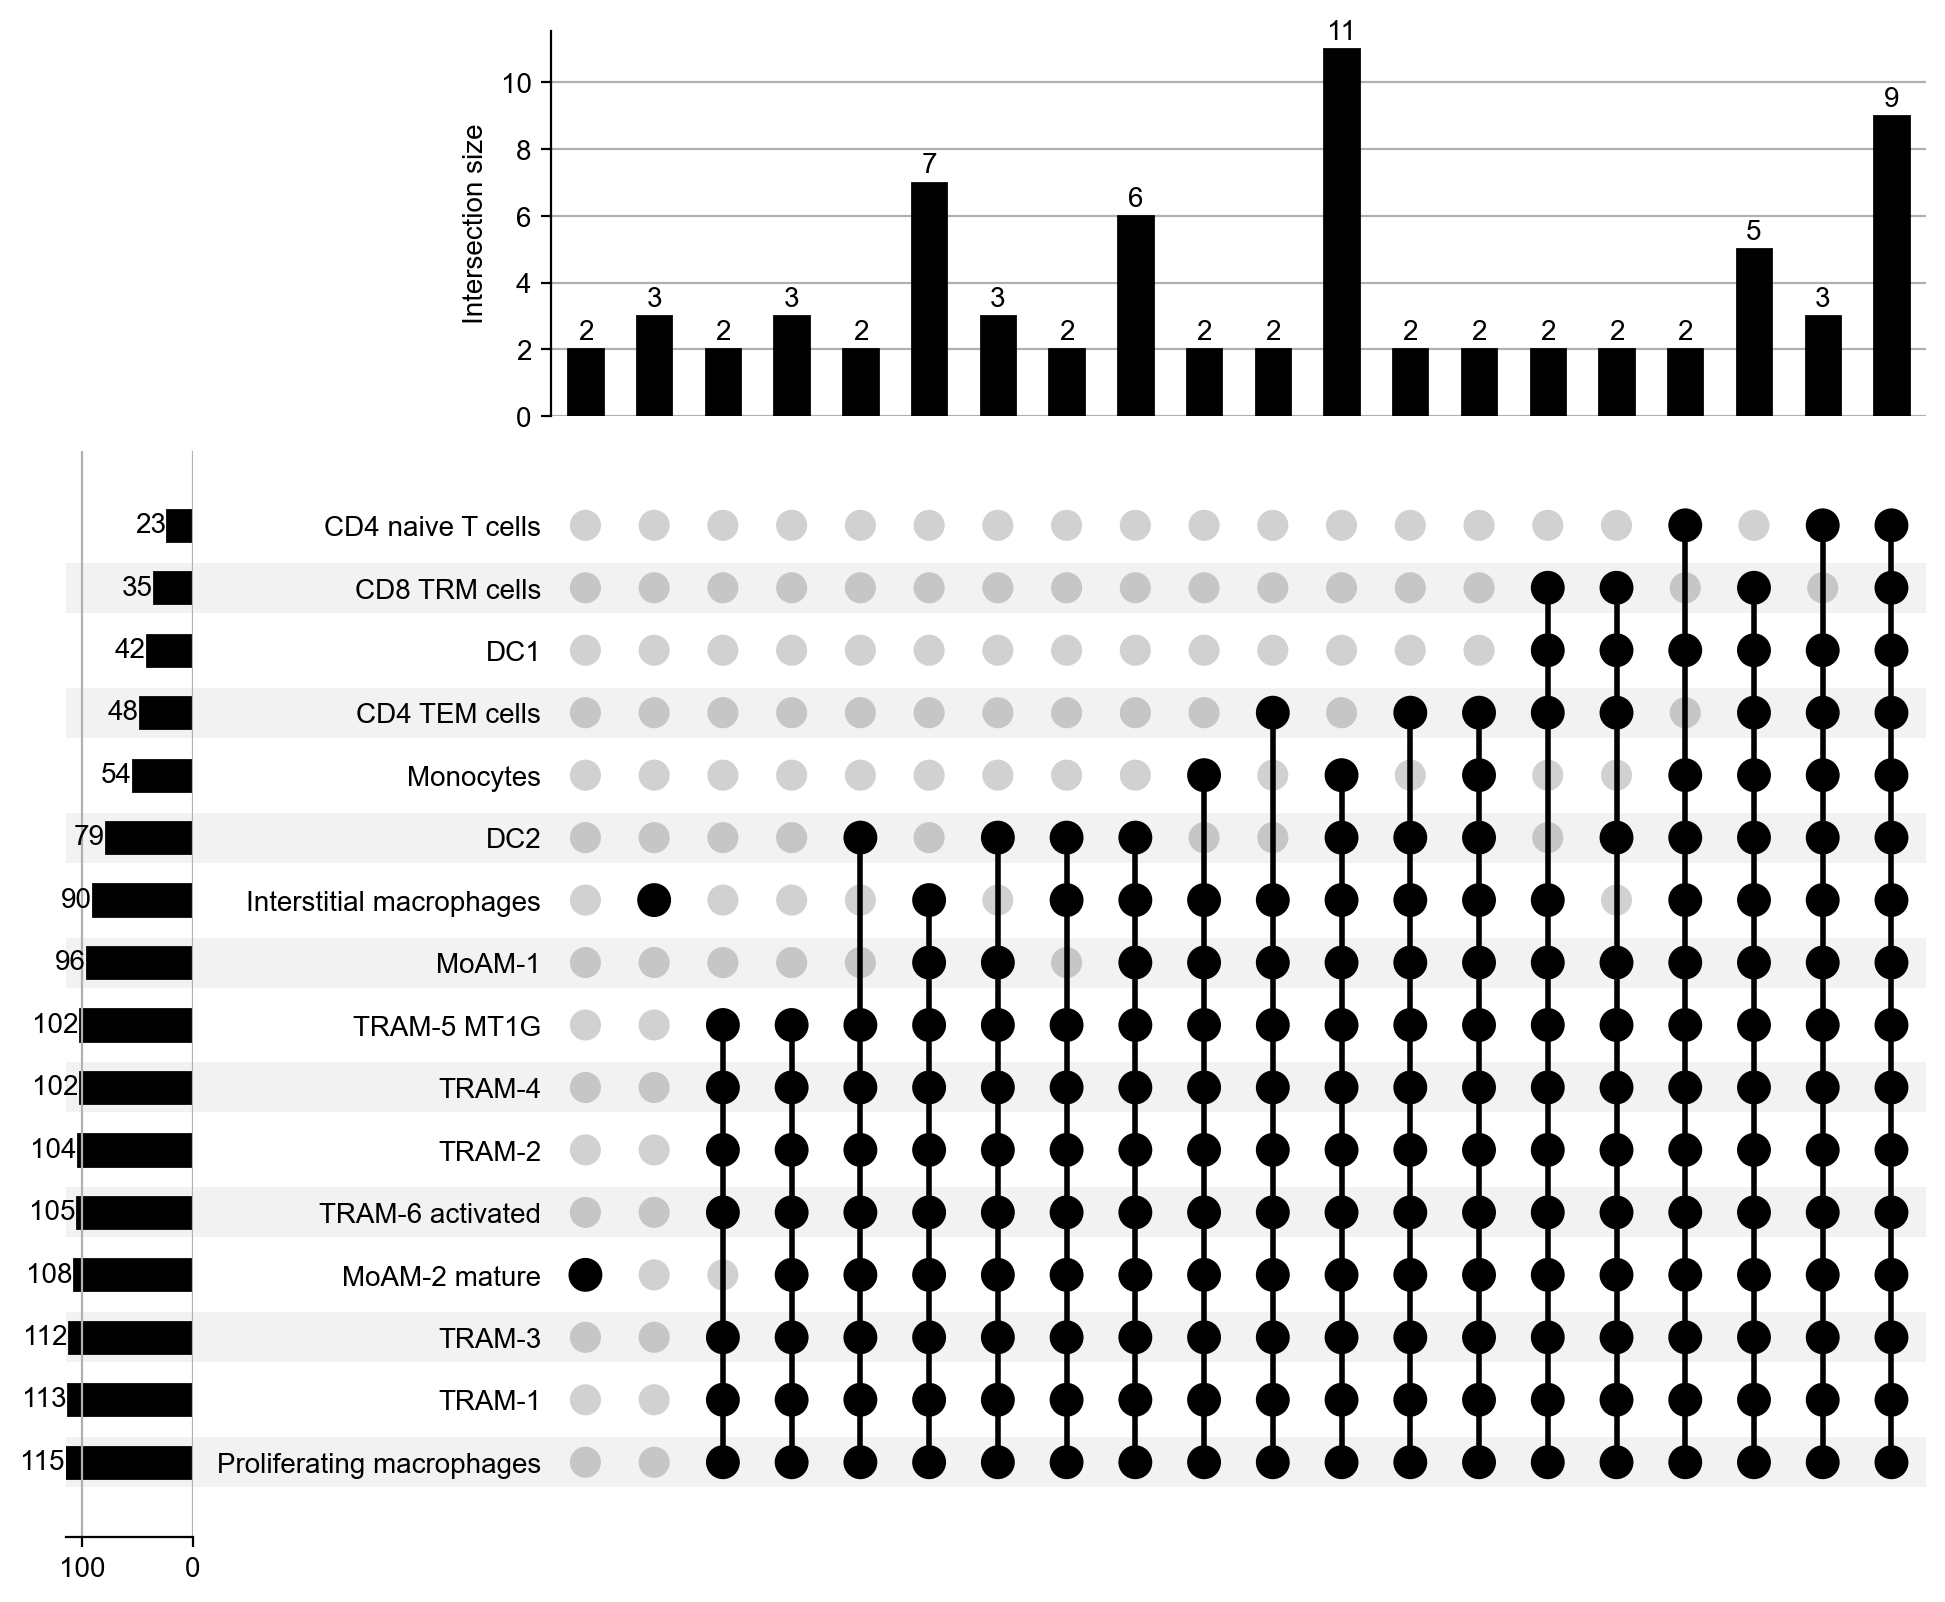

In [47]:
upsetplot.UpSet(
    upsetplot.from_contents(oxphos),
    min_subset_size=2,
    show_counts=True
)

Let's look at the 2 lists of genes:
* 9 genes that are everywhere
* genes that are up in all Macs + Monocytes (excluding DCs and T cells)

In [48]:
oxphos_upset = upsetplot.from_contents(oxphos)

### 2.1.1 List 1: leading edge in every significant cell type

In [ ]:
oxphos_all = oxphos_upset.xs(
    (True,) * len(oxphos_upset.index.names),
    level=tuple(oxphos_upset.index.names)
).reset_index(drop=True)
oxphos_all.sort_values('id')

,id
1,COX4I1
8,COX6A1
2,COX6B1
3,COX6C
6,COX7B
4,NDUFA4
0,NDUFC2
5,SLC25A3
7,SLC25A5


### 2.1.1 List 2: leading edge in every Mac cells type + Monocytes

Excluding the above

In [ ]:
oxphos_11_cts_no = ('DC1', 'DC2', 'CD4 TEM cells', 'CD8 TRM cells', 'CD4 naive T cells')
oxphos_11_cts = tuple(set(oxphos_upset.index.names) - set(oxphos_11_cts_no))
oxphos_macs_mono = oxphos_upset.xs(
    (True,) * len(oxphos_11_cts),
    level=oxphos_11_cts
).reset_index(drop=True)
oxphos_macs_mono.loc[~oxphos_macs_mono.id.isin(oxphos_all.id)].sort_values('id')

,id
22,ATP6V0B
1,ATP6V1F
3,COX5A
4,COX5B
7,COX7A2
20,COX8A
36,GPI
28,IDH2
23,LDHA
33,MRPL11


## 2.2 Monocytes

Processes enriched in Monocytes, right now excluding Purine metabolism

In [51]:
monocyte_terms = result.loc[
    result.cell_type.eq('Monocytes')
    & result.padj.lt(0.05)
    & result.Term.ne('Purine metabolism')
][['Term', 'ES', 'Leading edge']]

In [52]:
monocyte_terms['Leading edge'] = monocyte_terms['Leading edge'].str.split(';')

In [53]:
monocyte_terms['ES_sign'] = np.sign(monocyte_terms.ES)

Print all genes in the leading edge, and their pathway and direction for Monocytes

In [54]:
for _, r in monocyte_terms.sort_values(['ES_sign', 'Term']).iterrows():
    condition = r.ES_sign < 0 and "SSc-ILD" or "Hea-Con"
    print(f'[{condition}]\t{r.Term}\n\t{", ".join(sorted(r["Leading edge"]))}\n')

[SSc-ILD]	HALLMARK_ALLOGRAFT_REJECTION
	BCAT1, CAPG, CCL2, CCND3, CCR2, CD4, CD40, CD86, CSK, DEGS1, EIF4G3, FCGR2B, FGR, FLNA, GALNT1, HCLS1, HIF1A, HLA-DMA, HLA-DOA, HLA-DQA1, HLA-DRA, ICAM1, IFNGR2, IGSF6, IL4R, LCP2, LY86, NME1, PTPN6, RIPK2, SRGN, TGFB1, TIMP1, TLR2, UBE2N

[SSc-ILD]	HALLMARK_COAGULATION
	ADAM9, ANXA1, CAPN2, CD9, CFD, CPQ, CSRP1, CTSB, DUSP6, FN1, GSN, PEF1, PLAU, RABIF, RAC1, TIMP1

[SSc-ILD]	HALLMARK_COMPLEMENT
	ADAM9, ANXA5, CALM1, CALM3, CD36, CD59, CPQ, CSRP1, CTSB, CTSL, DUSP6, FCER1G, FCN1, FN1, GNAI2, HSPA5, ITGAM, LCP2, LGALS3, LIPA, PFN1, PIK3R5, PLA2G7, PLAUR, PPP4C, RABIF, RHOG, S100A9, TIMP1

[SSc-ILD]	HALLMARK_DNA_REPAIR
	ADRM1, ALYREF, APRT, BCAP31, DAD1, DCTN4, DGUOK, EDF1, ERCC1, GTF2A2, GUK1, HCLS1, HPRT1, ITPA, MPG, NELFE, NME1, NT5C, PNP, POLE4, POLR2E, POLR2F, POLR2J, RALA, RBX1, RPA3, SEC61A1, SRSF6, SUPT4H1, SURF1, TAF13, VPS28

[SSc-ILD]	HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
	ANPEP, BASP1, CALU, CAPG, CD59, COLGALT1, DAB2, EMP3, FLNA,

## 2.3 Which gene sets up in SSc-ILD in most MoAM and TRAM?

In [ ]:
for term, r in result.loc[
    (
        result.cell_type.str.contains('TRAM')
         | result.cell_type.str.contains('MoAM')
    )
    & result.ES.lt(0)
    & result.padj.lt(0.05)
].groupby('Term').apply(
    lambda x: pd.Series(
        [x.cell_type.nunique(), ', '.join(sorted(x.cell_type.unique()))],
        index=['n_cell_types', 'cell_types']
    )
).sort_values('n_cell_types', ascending=False).iterrows():
    # if r.n_cell_types < 6:
    #     break
    print(f'[{term}]\tIn <{r.n_cell_types}> cell types\n\t{r.cell_types}\n')


[HALLMARK_MYC_TARGETS_V1]	In <9> cell types
	MoAM-1, MoAM-2 mature, MoAM-3 profibrotic, TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_OXIDATIVE_PHOSPHORYLATION]	In <8> cell types
	MoAM-1, MoAM-2 mature, TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_DNA_REPAIR]	In <8> cell types
	MoAM-1, MoAM-2 mature, TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_FATTY_ACID_METABOLISM]	In <7> cell types
	MoAM-2 mature, TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_XENOBIOTIC_METABOLISM]	In <7> cell types
	MoAM-2 mature, TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_CHOLESTEROL_HOMEOSTASIS]	In <7> cell types
	MoAM-1, MoAM-2 mature, TRAM-1, TRAM-2, TRAM-3, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_COAGULATION]	In <7> cell types
	MoAM-1, MoAM-2 mature, TRAM-1, TRAM-3, TRAM-4, TRAM-5 MT1G, TRAM-6 activated

[HALLMARK_COMPLEMENT]	In <7> cell types
	MoAM-2 mature, TRAM-1, TRAM

## 2.4 Which genes are in leading edge of TNFa signaling for MoAMs?

In [56]:
moam_tnfa = result.loc[
    result.Term.eq('HALLMARK_TNFA_SIGNALING_VIA_NFKB')
    & result.padj.lt(0.05)
    & (
        result.cell_type.str.startswith('MoAM')
        | result.cell_type.str.startswith('Mono')
    )
][['cell_type', 'Leading edge']].set_index('cell_type')['Leading edge'].str.split(';').to_dict()

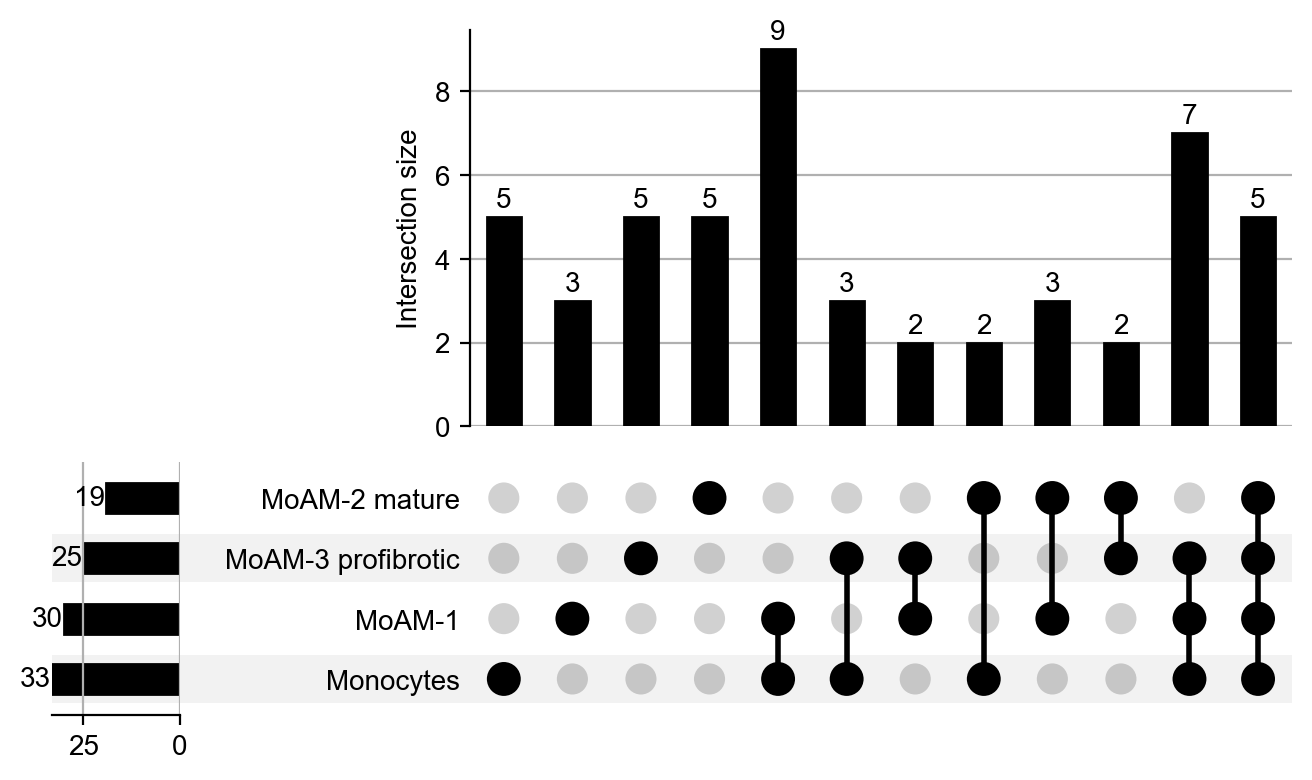

In [57]:
upsetplot.UpSet(
    upsetplot.from_contents(moam_tnfa),
    min_subset_size=2,
    show_counts=True
)

In [58]:
moam_tnfa_upset = upsetplot.from_contents(moam_tnfa)

Print 5 genes in all 4 cell types

In [ ]:
moam_tnfa_all = moam_tnfa_upset.xs(
    (True,) * len(moam_tnfa_upset.index.names),
    level=tuple(moam_tnfa_upset.index.names)
).reset_index(drop=True)
moam_tnfa_all.sort_values('id')

,id
2,KLF2
4,MAP3K8
3,MARCKS
1,PTPRE
0,SGK1


Print 7 genes in 3 cell types excluding `MoAM-2 mature`

In [ ]:
moam_tnfa_3_of_4 = moam_tnfa_upset.xs(
    (True,) * 3,
    level=('Monocytes', 'MoAM-1', 'MoAM-3 profibrotic')
).reset_index(drop=True)
moam_tnfa_3_of_4.loc[~moam_tnfa_3_of_4.id.isin(moam_tnfa_all.id)].sort_values('id')

,id
11,CD83
4,ETS2
6,FOSL2
5,IER3
2,RHOB
1,SERPINB8
9,ZFP36


## 2.5 Genes for Apoptosis

In [61]:
apoptosis_terms = result.loc[
    result.padj.lt(0.05)
    & result.Term.eq('HALLMARK_APOPTOSIS')
][['Term', 'ES', 'Leading edge', 'cell_type']]

In [62]:
apoptosis_terms['Leading edge'] = apoptosis_terms['Leading edge'].str.split(';')

In [63]:
apoptosis_terms['ES_sign'] = np.sign(apoptosis_terms.ES)

Print all genes in the leading edge, and their pathway and direction for Monocytes

In [64]:
for _, r in apoptosis_terms.sort_values(['ES_sign', 'Term']).iterrows():
    condition = r.ES_sign < 0 and "SSc-ILD" or "Hea-Con"
    print(f'[{condition} :: {r.cell_type}]\t{r.Term}\n\t{", ".join(sorted(r["Leading edge"]))}\n')

[SSc-ILD :: MoAM-1]	HALLMARK_APOPTOSIS
	BTG2, CD69, CDKN1A, EBP, EMP1, GPX1, GSN, HSPB1, IER3, LMNA, PEA15, RHOB, SLC20A1, SOD1, TIMP1, TNFRSF12A

[SSc-ILD :: TRAM-2]	HALLMARK_APOPTOSIS
	ANKH, ANXA1, BCL2L11, BID, CASP6, CD69, CDC25B, EBP, EMP1, FAS, GPX1, GPX4, GSN, HMGB2, HSPB1, KRT18, LGALS3, LMNA, MGMT, SOD1, TIMP1, TNF, TNFRSF12A, TSPO, VDAC2



## 2.6 Genes for Allograft rejection

In [65]:
allograft_terms = result.loc[
    result.padj.lt(0.05)
    & result.Term.eq('HALLMARK_ALLOGRAFT_REJECTION')
][['Term', 'ES', 'Leading edge', 'cell_type']]

In [66]:
allograft_terms['Leading edge'] = allograft_terms['Leading edge'].str.split(';')

In [67]:
allograft_terms['ES_sign'] = np.sign(allograft_terms.ES)

Print all genes in the leading edge, and their pathway and direction for Monocytes

In [68]:
for _, r in allograft_terms.sort_values(['ES_sign', 'Term']).iterrows():
    condition = r.ES_sign < 0 and "SSc-ILD" or "Hea-Con"
    print(f'[{condition} :: {r.cell_type}]\t{r.Term}\n\t{", ".join(sorted(r["Leading edge"]))}\n')

[SSc-ILD :: CD4 TEM cells]	HALLMARK_ALLOGRAFT_REJECTION
	B2M, CAPG, CCL4, CCL5, CCND3, CD247, CD3D, CD3E, CD3G, CD7, CD8A, CD8B, CSK, CXCR3, IL2RB, LCK, LTB, SIT1, SOCS1, SRGN, TIMP1

[SSc-ILD :: CD8 TRM cells]	HALLMARK_ALLOGRAFT_REJECTION
	B2M, CAPG, CCL4, CCL5, CD2, CD3D, CD3E, CD3G, CD7, CD8A, CD8B, CXCR3, GZMA, GZMB, LCK, LTB, SRGN

[SSc-ILD :: MoAM-2 mature]	HALLMARK_ALLOGRAFT_REJECTION
	BCAT1, CAPG, CCL2, CCR5, CD47, CFP, CSF1, FAS, FCGR2B, FGR, IFNGR2, IGSF6, NME1, SRGN, ST8SIA4, TIMP1, TLR6

[SSc-ILD :: Monocytes]	HALLMARK_ALLOGRAFT_REJECTION
	BCAT1, CAPG, CCL2, CCND3, CCR2, CD4, CD40, CD86, CSK, DEGS1, EIF4G3, FCGR2B, FGR, FLNA, GALNT1, HCLS1, HIF1A, HLA-DMA, HLA-DOA, HLA-DQA1, HLA-DRA, ICAM1, IFNGR2, IGSF6, IL4R, LCP2, LY86, NME1, PTPN6, RIPK2, SRGN, TGFB1, TIMP1, TLR2, UBE2N



## 2.7 _IFNG_ response

Cell types with significant enrichment in _IFNG_ response in Healthy side

In [69]:
result.loc[
    result.Term.eq('HALLMARK_INTERFERON_GAMMA_RESPONSE')
    & result.padj.lt(0.05)
    & result.ES.gt(0)
].cell_type

25                          DC2
26                       MoAM-1
26                MoAM-2 mature
26           MoAM-3 profibrotic
26                    Monocytes
26     Interstitial macrophages
26    Proliferating macrophages
26                       TRAM-2
26             TRAM-6 activated
Name: cell_type, dtype: object

In [70]:
ifng = result.loc[
    result.Term.eq('HALLMARK_INTERFERON_GAMMA_RESPONSE')
    & result.padj.lt(0.05)
][['cell_type', 'Leading edge']].set_index('cell_type')['Leading edge'].str.split(';').to_dict()

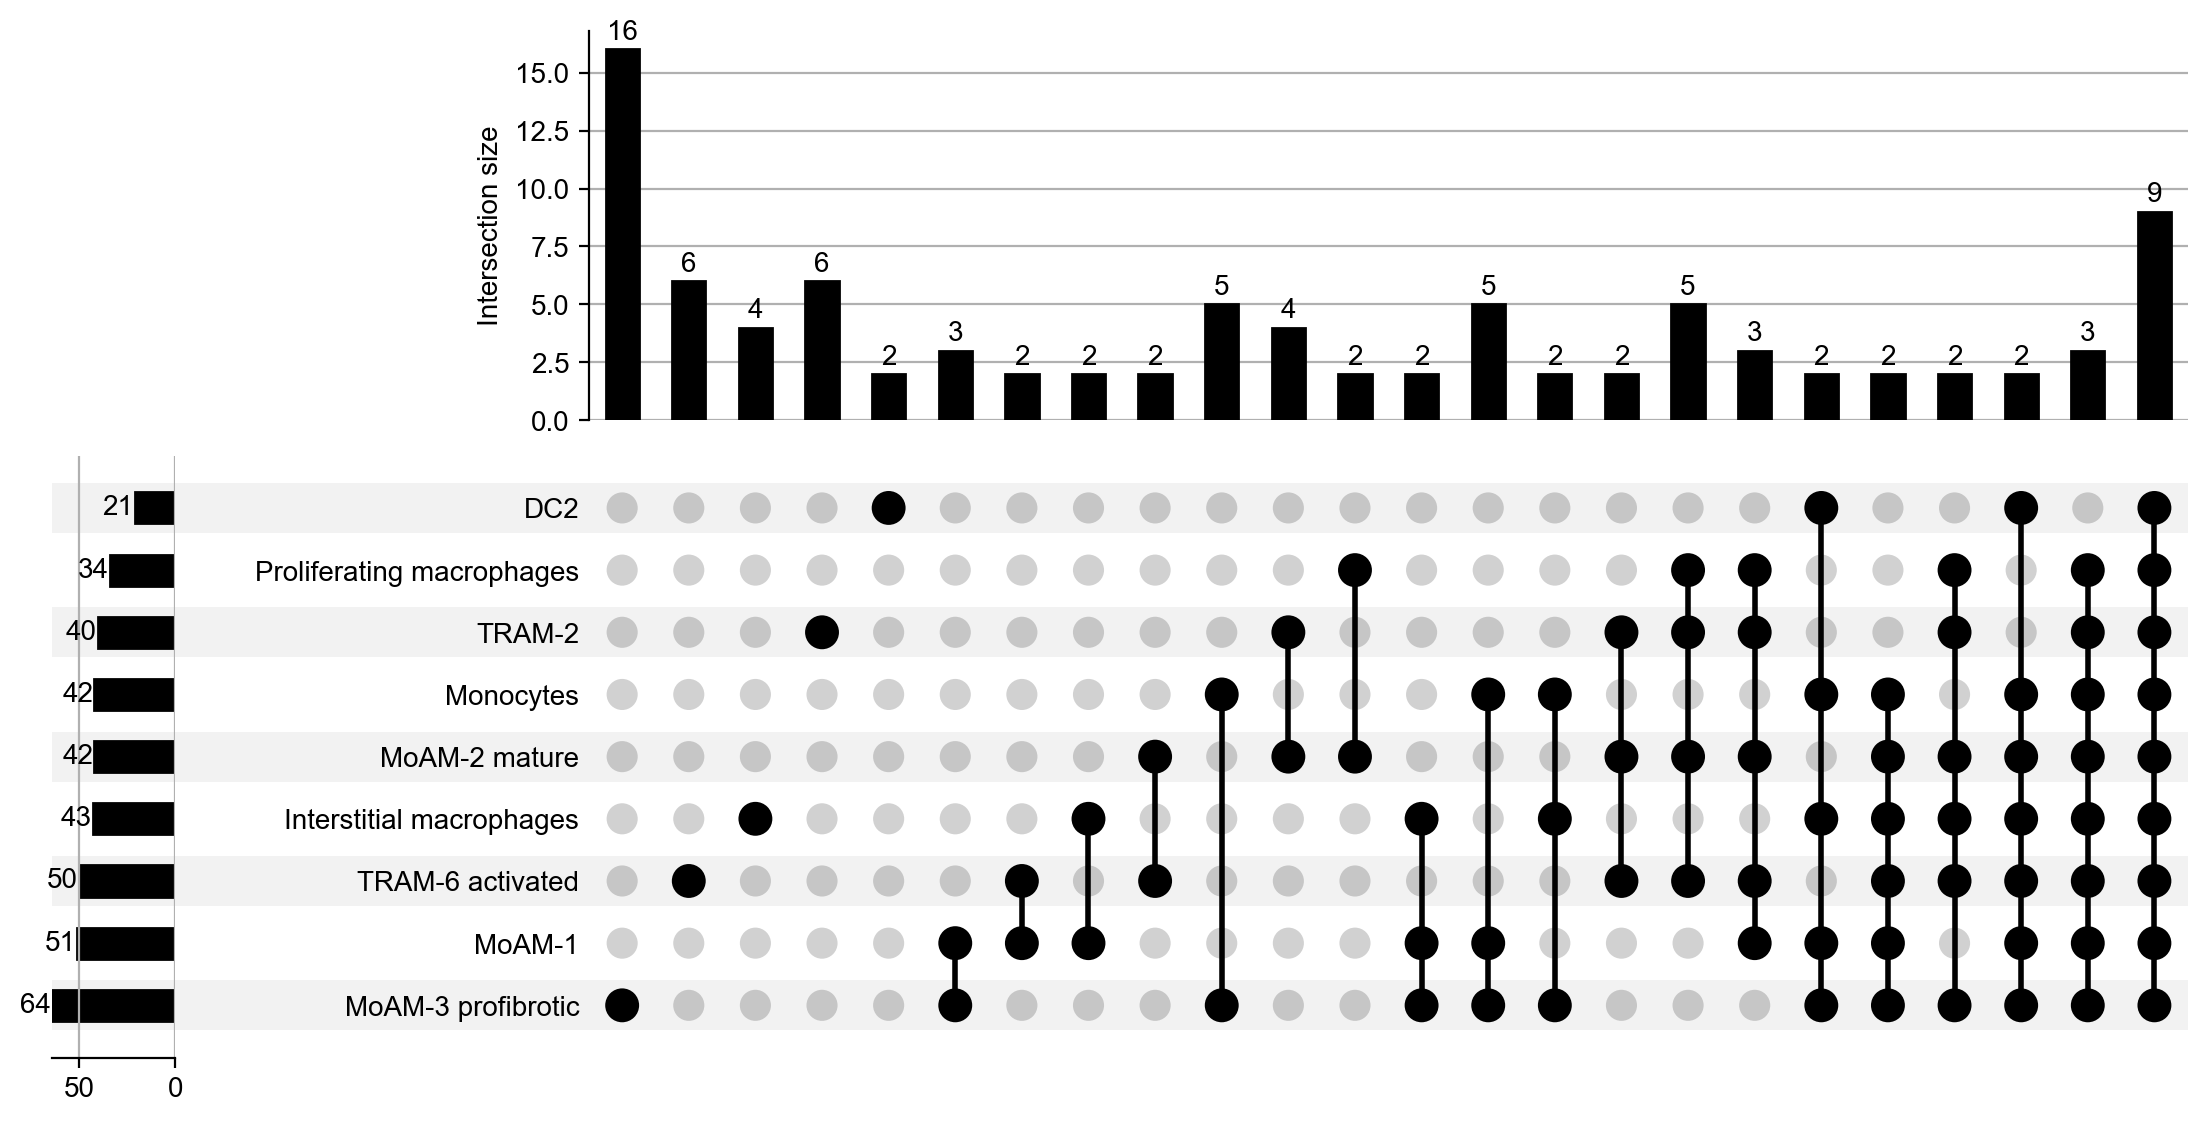

In [71]:
upsetplot.UpSet(
    upsetplot.from_contents(ifng),
    min_subset_size=2,
    show_counts=True
)

In [72]:
ifng_upset = upsetplot.from_contents(ifng)

### 2.7.1 List 1: leading edge in every significant cell type

In [ ]:
ifng_all = ifng_upset.xs(
    (True,) * len(ifng_upset.index.names),
    level=tuple(ifng_upset.index.names)
).reset_index(drop=True)
ifng_all.sort_values('id')

,id
3,APOL6
4,CIITA
5,IFI44L
6,MX1
7,PARP14
2,RNF213
0,SAMD9L
1,STAT1
8,STAT3


### 2.7.2 List 2: Let's drop DC2

In [ ]:
ifng_no_dc = ifng_upset.xs(
    (True,) * (len(ifng_upset.index.names) - 1),
    level=tuple(set(ifng_upset.index.names) - set(['DC2']))
).reset_index(drop=True)
ifng_no_dc.sort_values('id')

,id
11,ADAR
3,APOL6
4,CIITA
5,IFI44L
6,MX1
10,OAS2
7,PARP14
2,RNF213
0,SAMD9L
1,STAT1
